Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


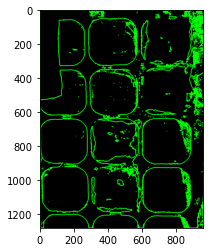

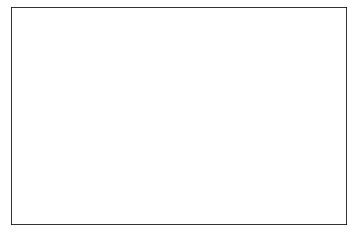

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('./seedling_imgs/top_1.jpg', cv2.IMREAD_UNCHANGED)

# proccess image
img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#set a thresh
thresh = 100
#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(img.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
 
plt.imshow(img_contours,'gray'),plt.show()
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

Our goal is to be able to look at images, and normalize them to each other such that we can tell the difference in plant foliage, regardless of shots from different heights, of different croppings, from different angles. 

One approach I was thinking about for this was to find a distinct static object in the image (such as one of the squares in our top down views, or a pot). It would then use the size of this object in each image to "normalize" the scales of each photo. 

Another approach to this would be to use homography to map one image to another, and get the change in scale and position from the change in location of the connections between the two. In the following, we try to use homography to map one image on to another. 


In [3]:
MIN_MATCH_COUNT = 10
img1 = cv2.imread('./seedling_imgs/top_1.jpg',0)          # queryImage
img2 = cv2.imread('./seedling_imgs/top_2.jpeg',0) # trainImage
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [4]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

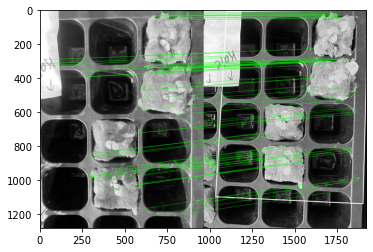

(<matplotlib.image.AxesImage at 0x7fc380f33460>, None)

In [5]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3, 'gray'),plt.show()

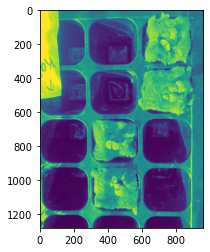

In [6]:

# Four corners of the book in source image
pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]])

# Four corners of the book in destination image.
pts_dst = np.array([[318, 256],[534, 372],[316, 670],[73, 473]])
 
# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)
 
# Warp source image to destination based on homography
im_out = cv2.warpPerspective(img1, h, (img2.shape[1],img2.shape[0]))
 
# Display images
plt.imshow(img1)



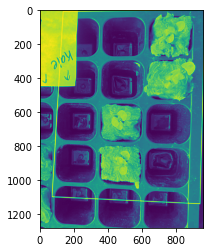

In [7]:
plt.imshow(img2)

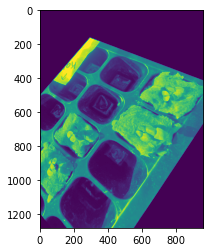

In [8]:
plt.imshow(im_out)